In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
test_path="/content/drive/MyDrive/AI and Machine Learning/FruitinAmazon/test"
train_path="/content/drive/MyDrive/AI and Machine Learning/FruitinAmazon/train"

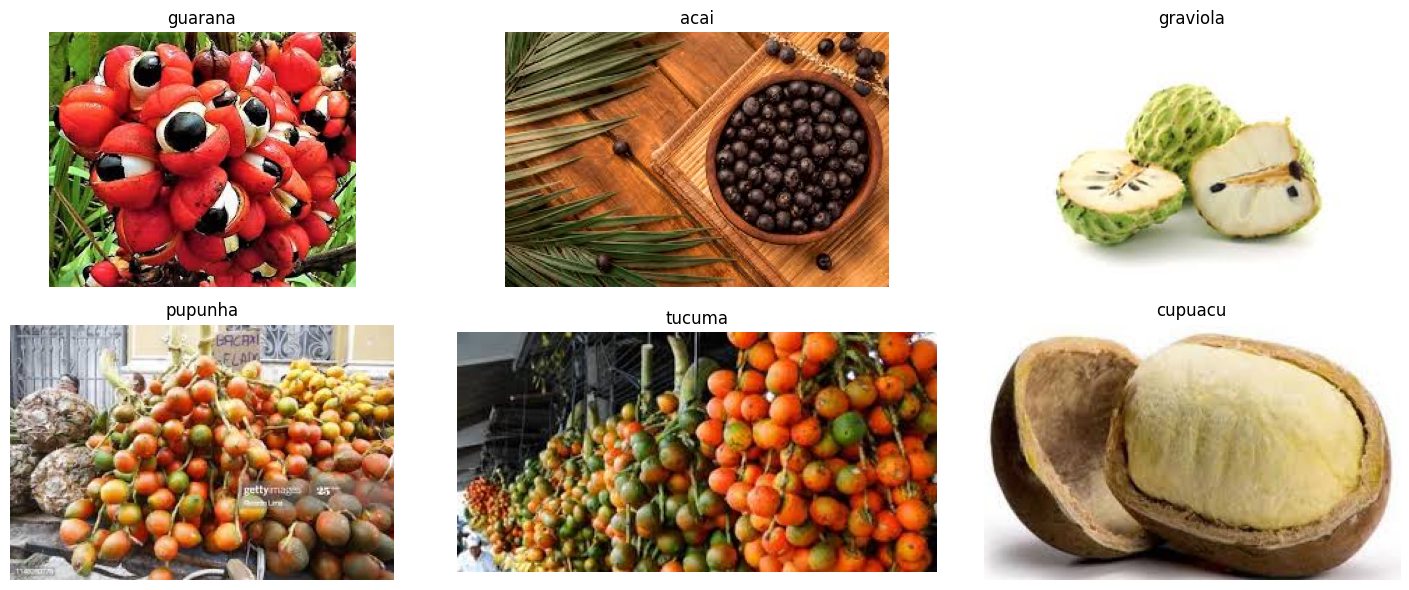

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class_dirs = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]

selected_images = []
labels = []
for class_name in class_dirs:
    class_path = os.path.join(train_path, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if images:  # Ensure the folder is not empty
        img_file = random.choice(images)
        selected_images.append(os.path.join(class_path, img_file))
        labels.append(class_name)


cols = 3

fig, axes = plt.subplots(2, cols, figsize=(15, 6))
axes = axes.flatten()

for i, (img_path, label) in enumerate(zip(selected_images, labels)):
    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis('off')


for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
from PIL import Image, UnidentifiedImageError


corrupted_images = []

for class_name in os.listdir(train_path):
    class_path = os.path.join(train_path, class_name)

    # Skip if not a directory
    if not os.path.isdir(class_path):
        continue

    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)

        # Skip non-image files
        if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        try:
            with Image.open(image_path) as img:
                img.verify()  # Verify image integrity
        except Exception:
            corrupted_images.append(image_path)
            os.remove(image_path)
            print(f"Removed corrupted image: {image_path}")

if not corrupted_images:
    print("No corrupted images found.")


No corrupted images found.


In [ ]:
import tensorflow as tf


img_height = 224
img_width = 224
batch_size = 32
validation_split = 0.2  # 80% training, 20% validation


rescale = tf.keras.layers.Rescaling(1./255)  # Normalize pixel values to [0, 1]

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Random horizontal flip
    tf.keras.layers.RandomRotation(0.2),      # Random rotation
    tf.keras.layers.RandomZoom(0.2),          # Random zoom
    tf.keras.layers.RandomContrast(0.2),      # Random contrast adjustment
])


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Apply the normalization (Rescaling) to the dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

# Create validation dataset with normalization
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

# Apply the normalization (Rescaling) to the validation dataset
val_ds = val_ds.map(lambda x, y: (rescale(x), y))


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [ ]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential([
    # Data augmentation applied using Lambda layer
    layers.Lambda(data_augmentation, input_shape=(224, 224, 3)),
    # Rescaling layer to normalize pixel values
    layers.Rescaling(1./255),

    # First Convolutional Block
    Conv2D(32, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(64, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(128, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fourth Convolutional Block
    Conv2D(256, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flatten the output of the last Conv2D layer
    Flatten(),

    # First Fully Connected Layer
    Dense(512, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Second Fully Connected Layer
    Dense(256, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Third Fully Connected Layer
    Dense(128, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Fourth Fully Connected Layer
    Dense(64, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Output Layer with 10 neurons (for classification task with 10 classes)
    Dense(10, activation='softmax')
])

# Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy as the metric
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use this for integer labels
    metrics=['accuracy']
)

# Print a summary of the model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,257,930 (100.17 MB)

 Trainable params: 26,255,050 (100.16 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [ ]:
from tensorflow.keras.applications import VGG16
# Load the VGG16 model pre-trained on ImageNet, without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
  layer.trainable = False


from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces dimensions (height, width) to a single vector per image
x = Dense(1024, activation='relu')(x) # Fully connected layer with 1024 neurons
x = Dense(10, activation='softmax')(x) # Output layer for 10 classes (with softmax for multi-class classification)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
)

# Apply normalization (Rescaling) to the test dataset
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
model.save("fruit_classification_model.h5")
# Print the evaluation results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8000 - loss: 0.7621


Test Loss: 0.7620907425880432
Test Accuracy: 0.800000011920929


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# List of class labels (replace with your actual labels)
class_names = ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']

# Get predictions on the test set
predictions = model.predict(test_ds)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=-1)

# Get true labels from the test dataset
true_labels = []
for _, labels in test_ds:
    # For categorical labels, labels are already one-hot encoded
    true_labels.extend(np.argmax(labels.numpy(), axis=-1))  # Convert one-hot encoded labels to class indices
true_labels = np.array(true_labels)

# Print classification report with actual class names
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
              precision    recall  f1-score   support

        acai       0.71      1.00      0.83         5
     cupuacu       0.71      1.00      0.83         5
    graviola       1.00      1.00      1.00         5
     guarana       1.00      0.40      0.57         5
     pupunha       0.71      1.00      0.83         5
      tucuma       1.00      0.40      0.57         5

    accuracy                           0.80        30
   macro avg       0.86      0.80      0.77        30
weighted avg       0.86      0.80      0.77        30



In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Define image size (same as during training)
img_height = 128  # Example image height
img_width = 128   # Example image width

# List of class labels (replace this with your actual class labels)
class_names = ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']

# Path to the test image
test_image_path = "/content/drive/MyDrive/AI and Machine Learning/FruitinAmazon/test/tucuma/download (1).jpeg"

# Load the image and resize to the target size
img = image.load_img(test_image_path, target_size=(img_height, img_width))  # Use the same target size as during training

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add batch dimension (since the model expects a batch of images)
img_array = np.expand_dims(img_array, axis=0)  # Shape becomes (1, img_height, img_width, 3)

# Apply the same rescaling (normalization) as in training
rescale = tf.keras.layers.Rescaling(1./255)  # Normalize pixel values to [0, 1]
img_array = rescale(img_array)  # Apply rescaling

# Make prediction using the model
predictions = model.predict(img_array)

# Convert predicted probabilities to class label
predicted_class_index = np.argmax(predictions, axis=-1)[0]  # Get the class with the highest probability
predicted_class_name = class_names[predicted_class_index]  # Map to the actual class name

print(f"The predicted class is: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
The predicted class is: tucuma
